In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from IPython.display import display, HTML
from typing import List
from mprompt.modules.emb_diff_module import EmbDiffModule
import numpy as np
import matplotlib
import imodelsx.util
from copy import deepcopy
import re
import mprompt.viz
import scipy.special
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from mprompt.methods.m4_evaluate import D5_Validator
import openai
from mprompt.modules.fmri_module import fMRIModule

openai.api_key_path = os.path.expanduser('~/.OPENAI_KEY')

def moving_average(a, n=3):
    assert n % 2 == 1, 'n should be odd'
    diff = n // 2
    vals = []
    # calculate moving average in a window 2
    # (1, 4)
    for i in range(diff, len(a) + diff):
        l = i - diff
        r = i + diff + 1
        vals.append(np.mean(a[l: r]))
    return np.nan_to_num(vals)
nlp = English()
nlp.tokenizer = Tokenizer(nlp.vocab, token_match=re.compile(r'\S+').match) # only split on whitespace

# Get prompts

In [2]:
# expls = ['baseball','animals','water','movement','religion','time','technology']
# interesting_expls = ['food', 'numbers', 'physical contact', 'time', 'laughter', 'age', 'clothing']
# expls = ['movement', 'numbers', 'time', 'relationships', 'sounds', 'emotion', 'food']
# expls = ['food', 'emotion', 'relationships', 'sounds', 'time', 'movement', 'numbers']
voxels = [('movement', 'UTS01',	7), ('numbers', 'UTS03', 55), ('time', 'UTS03', 19), ('relationships', 'UTS01', 21), ('sounds', 'UTS03', 35), ('emotion', 'UTS03', 23), ('food', 'UTS03', 46)]
expls = [v[0] for v in voxels]

In [3]:
prompt_init = 'Write the beginning paragraph of a story about "{expl}". Make sure it contains several references to "{expl}".'
prompt_continue = 'Write the next paragraph of the story, but now make it about "{expl}". Make sure it contains several references to "{expl}".'
prompts = [prompt_init.format(expl=expls[0])] + [prompt_continue.format(expl=expl) for expl in expls[1:]]
for p in prompts:
    print(p)

Write the beginning paragraph of a story about "movement". Make sure it contains several references to "movement".
Write the next paragraph of the story, but now make it about "numbers". Make sure it contains several references to "numbers".
Write the next paragraph of the story, but now make it about "time". Make sure it contains several references to "time".
Write the next paragraph of the story, but now make it about "relationships". Make sure it contains several references to "relationships".
Write the next paragraph of the story, but now make it about "sounds". Make sure it contains several references to "sounds".
Write the next paragraph of the story, but now make it about "emotion". Make sure it contains several references to "emotion".
Write the next paragraph of the story, but now make it about "food". Make sure it contains several references to "food".


# Get paragraphs

In [4]:
def get_paragraphs(
        prompts,
        checkpoint='gpt-3.5-turbo',
        PROMPT_FIRST_PREFIX='Write the next paragraph of the story, but now make it about',
        PROMPT_NEXT_PREFIX='Write the beginning paragraph of a story about'
):
    # example messages
    # [
    #   {'role': 'system', 'content': 'You are a helpful assistant.'},
    #   {'role': 'user', 'content': 'Write the beginning paragraph of a story about "baseball". Make sure it contains several references to "baseball".'},
    #   {'role': 'assistant', 'content': 'The crack of the bat echoed through the stadium as the ball soared over the outfield fence. The crowd erupted into cheers, their excitement palpable. It was a beautiful day for baseball, with the sun shining down on the field and the smell of freshly cut grass filling the air. The players on the field were focused and determined, each one ready to give their all for their team. Baseball was more than just a game to them; it was a passion, a way of life. And as they took their positions on the field, they knew that anything was possible in this great game of baseball.'},
    #   {'role': 'user', 'content': 'Write the next paragraph of the story, but now make it about "animals". Make sure it contains several references to "animals".'},
    # ]

    llm = mprompt.llm.get_llm(checkpoint)
    response = None
    messages = [{"role": "system", "content": "You are a helpful assistant."}]
    all_content = []
    for i in range(len(prompts)):
        messages.append({"role": "user", "content": prompts[i]})
        all_content.append(messages[-1])
        # for message in messages:
            # print(message)
        response = llm(messages)

        if response is not None:
            response_text = response['choices'][0]['message']['content']
            messages.append({"role": "assistant", "content": response_text})
            all_content.append(messages[-1])

        # need to drop beginning of story whenever we approach the tok limit
        # gpt-3.5.turbo has a limit of 4096, and it cant generate beyond that
        num_tokens = response['usage']['total_tokens']
        # print('num_tokens', num_tokens)
        if num_tokens >= 3200:
            # drop the first (assistant, user) pair in messages
            messages = [messages[0]] + messages[3:]

            # rewrite the original prompt to now say beginning paragraph rather than next paragraph
            messages[1]['content'] = messages[1]['content'].replace(PROMPT_FIRST_PREFIX, PROMPT_NEXT_PREFIX)
    
    # extract out paragraphs
    paragraphs = [d['content'] for d in all_content if d['role'] == 'assistant']
    paragraphs
    assert len(paragraphs) == len(prompts)
    return paragraphs
paragraphs = get_paragraphs(prompts)

cached!
cached!
cached!
cached!
cached!
cached!
cached!


In [5]:
for para in paragraphs:
    print(para)

The world is in constant motion, always moving and changing. From the tiniest particles to the largest celestial bodies, everything is in a state of movement. It's as if the universe itself is alive, pulsing with energy and vitality. Even when we're still, our bodies are in motion - our hearts beating, our lungs expanding and contracting, our blood flowing through our veins. Movement is the essence of life, the very thing that propels us forward and allows us to experience all that the world has to offer. And yet, despite its ubiquity, movement remains one of the great mysteries of existence - a force that we can observe and measure, but never fully understand.
Numbers, like movement, are an integral part of our world. They are the language of science, the foundation of mathematics, and the key to unlocking the secrets of the universe. From the tiniest subatomic particles to the vast expanse of space, everything can be quantified and measured using numbers. They allow us to make sense 

# Visualize data heatmap

### Get embedding dists

In [6]:
# mod = EmbDiffModule()
val = D5_Validator()

loading model weights


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

done


In [7]:
story_running = ''
scores = {}
for i in range(len(expls)):
# for i in range(1):
    expl = expls[i].lower()
    text = paragraphs[i]
    words = text.split()
    prompt = prompts[i]

    ngrams = imodelsx.util.generate_ngrams_list(text.lower(), ngrams=3, tokenizer_ngrams=nlp.tokenizer)
    ngrams = [words[0], words[0] + ' ' + words[1]] + ngrams

    # # embdiff-based viz
    # mod._init_task(expl)    
    # neg_dists = mod(ngrams)
    # assert len(ngrams) == len(words) == len(neg_dists)
    # # neg_dists = scipy.special.softmax(neg_dists)
    # # plt.plot(neg_dists)
    # # plt.plot(moving_average(neg_dists, n=5))
    # neg_dists = moving_average(neg_dists, n=3)
    # neg_dists = (neg_dists - neg_dists.min()) / (neg_dists.max() - neg_dists.min())
    # neg_dists = neg_dists / 2 + 0.5 # shift to 0.5-1 range
    # s = mprompt.viz.colorize(words, neg_dists, title=expl, subtitle=prompt)

    # validator-based viz
    probs = np.array(val.validate_w_scores(expl, ngrams))
    probs_disp = moving_average(probs, n=3)
    probs_disp = probs_disp / 2 + 0.5 # shift to 0.5-1 range
    s = mprompt.viz.colorize(words, probs_disp, title=expl, subtitle=prompt)
    
    # viz
    display(HTML(s))
    story_running += ' ' + s

with open('../results/story_running.html', 'w') as f:
    f.write(story_running)

# Quantify synthetic data
Calculate mean match for each paragraph to each explanation

In [8]:
n = len(expls)
scores = np.zeros((n, n))
for i in tqdm(range(n)):
    expl = expls[i]
    for j in range(n):
        text = paragraphs[j].lower()
        words = text.split()

        ngrams = imodelsx.util.generate_ngrams_list(text, ngrams=3, tokenizer_ngrams=nlp.tokenizer)
        ngrams = [words[0], words[0] + ' ' + words[1]] + ngrams

        # validator-based viz
        probs = np.array(val.validate_w_scores(expl, ngrams)) > 0.5
        scores[i, j] = probs.mean()

100%|██████████| 7/7 [02:02<00:00, 17.49s/it]


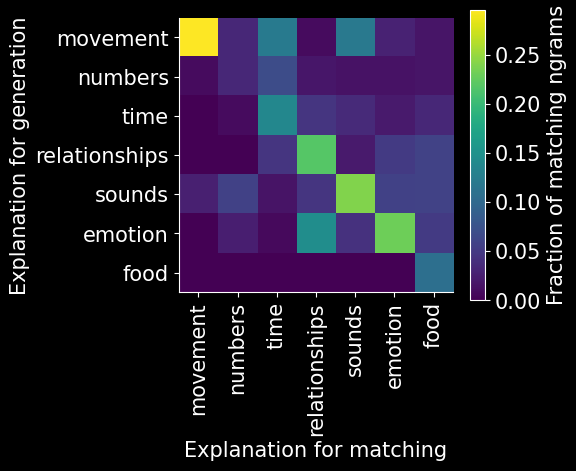

In [9]:
s = scores
# s = scipy.special.softmax(scores, axis=1)
# s = (s - s.min()) / (s.max() - s.min())
plt.style.use('dark_background')
plt.figure(figsize=(6, 5))
plt.imshow(s)
plt.xticks(range(n), expls, rotation=90)
plt.yticks(range(n), expls)
plt.ylabel('Explanation for generation')
plt.xlabel('Explanation for matching')
plt.colorbar(label='Fraction of matching ngrams')
plt.tight_layout()
plt.show()

# Test modules on the generated stories

In [13]:
n = len(expls)
scores = np.zeros((n, n))
scores_max = np.zeros((n, n))
all_scores = {}
for i in tqdm(range(n)):
    # expl = expls[i]
    (expl, subject, voxel_num_best) = voxels[i]
    mod = fMRIModule(voxel_num_best=voxel_num_best, subject=subject)
    ngrams_list = []

    for j in range(n):
        text = paragraphs[j].lower()
        words = text.split()
        ngrams = imodelsx.util.generate_ngrams_list(text, ngrams=3, tokenizer_ngrams=nlp.tokenizer)
        ngrams = [words[0], words[0] + ' ' + words[1]] + ngrams
        ngrams_list.append(ngrams)

    # all appended in one big list to avoid reloading model
    ngrams_scores_all = mod(sum(ngrams_list, []))

    # extract out mean score for each story
    ngrams_scores_list = []
    offset = 0
    for j in range(n):
        ngrams_story = ngrams_list[j]
        ngrams_scores_story = ngrams_scores_all[offset: offset + len(ngrams_story)]
        ngrams_scores_list.append(ngrams_scores_story)
        scores[i, j] = ngrams_scores_story.mean()
        scores_max[i, j] = ngrams_scores_story.max()
        offset += len(ngrams_story)
    all_scores[i] = deepcopy(ngrams_scores_list)

  0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

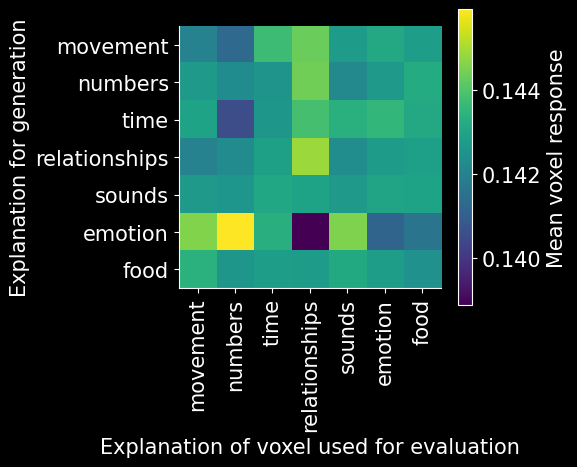

In [70]:
s = scores
s = scipy.special.softmax(scores, axis=1)
# s = (s - s.min()) / (s.max() - s.min())
plt.style.use('dark_background')
plt.figure(figsize=(6, 5))
plt.imshow(s)
plt.xticks(range(n), expls, rotation=90)
plt.yticks(range(n), expls)
plt.ylabel('Explanation for generation')
plt.xlabel('Explanation of voxel used for evaluation')
plt.colorbar(label='Mean voxel response')
plt.tight_layout()
plt.show()

### Look at module responses for an individual story

In [67]:
# show all rows
pd.set_option('display.max_rows', 120)
pd.DataFrame.from_dict({
    'score': ngrams_scores_list[-1],
    'ngram': ngrams_list[-1],
}).sort_values('score', ascending=False)

,score,ngram
19,0.047881,"sustains us, nourishes"
59,0.047183,"people together, create"
98,0.044599,of our connection
89,0.042965,we can enjoy
31,0.041779,"or complex, healthy"
14,0.041715,part of our
61,0.039641,"create memories, and"
102,0.039308,the earth and
101,0.038484,to the earth
39,0.037933,be prepared in
